In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!pip install tensorflow_datasets
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dataset imdb_reviews downloaded and prepared to C:\Users\Dheeraj Doppalapudi\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [3]:
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

In [4]:
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

In [5]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [6]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [8]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 6s 4ms/step - loss: 0.5059 - accuracy: 0.7293 - val_loss: 0.3589 - val_accuracy: 0.8409
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.2527 - accuracy: 0.9021 - val_loss: 0.3602 - val_accuracy: 0.8425
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1089 - accuracy: 0.9709 - val_loss: 0.4388 - val_accuracy: 0.8310
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0321 - accuracy: 0.9949 - val_loss: 0.5303 - val_accuracy: 0.8258
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0107 - accuracy: 0.9990 - val_loss: 0.5947 - val_accuracy: 0.8270
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0045 - accuracy: 0.9996 - val_loss: 0.6393 - val_accuracy: 0.8272
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 0.6906 - val_accuracy: 0.8269
Epoch 

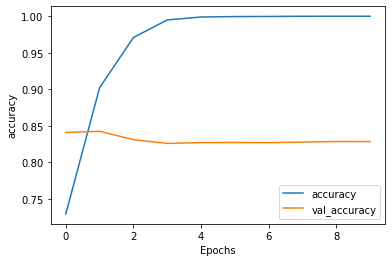

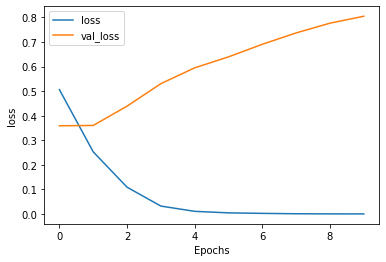

In [11]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [13]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [14]:
# use this if running in google colab for visualization.
"""try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')
  """

"try:\n  from google.colab import files\nexcept ImportError:\n  pass\nelse:\n  files.download('vecs.tsv')\n  files.download('meta.tsv')\n  "

In [15]:
sentence = "this is really a good and impressive movie"
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)
padded = pad_sequences(sequence,maxlen=max_length)
if model.predict(padded)>0.5:
  print("Positive")
else:
  print("Negative")
print(model.predict(padded))

[[12, 7, 64, 4, 50, 3, 1157, 18]]
Negative
[[0.41217908]]


In [16]:
len(training_labels_final)

25000

In [20]:
import gradio as gr

def sentiment_finder(str_inp):
    sequence = tokenizer.texts_to_sequences([str_inp])
    padded = pad_sequences(sequence,maxlen=max_length)
    if model.predict(padded)>0.5:
      return "Positive"
    else:
      return "Negative"

inputs=gr.inputs.Textbox(lines=7, placeholder="Text Here...")
show_work = gr.Interface(fn=sentiment_finder, inputs=inputs, outputs="text")
show_work.launch()

Running locally at: http://127.0.0.1:7863/
To create a public link, set `share=True` in `launch()`.
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7863/', None)